In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# #the file is uploaded, unzip it:
# import zipfile
# import os

# # Replace with the exact uploaded filename if different
# zip_path = '/content/drive/MyDrive/archive.zip'

# import zipfile
# import os

# # Path to extract the contents
# extract_path = '/content/banana_leaf_dataset'

# # Extract the archive.zip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# # Verify extraction
# print("Extracted folders:", os.listdir(extract_path))


In [ ]:
# import os
# import shutil
# import random

# # Paths to original and augmented sets
# original_path = '/content/banana_leaf_dataset/BananaLSD/OriginalSet'
# augmented_path = '/content/banana_leaf_dataset/BananaLSD/AugmentedSet'

# # Temporary merged folder
# merged_path = '/content/banana_leaf_merged'
# os.makedirs(merged_path, exist_ok=True)

# # Merge both sets
# for class_name in os.listdir(original_path):
#     orig_class_dir = os.path.join(original_path, class_name)
#     aug_class_dir = os.path.join(augmented_path, class_name)
#     merged_class_dir = os.path.join(merged_path, class_name)
#     os.makedirs(merged_class_dir, exist_ok=True)

#     # Copy original images
#     for file in os.listdir(orig_class_dir):
#         shutil.copy(os.path.join(orig_class_dir, file), merged_class_dir)

#     # Copy augmented images
#     for file in os.listdir(aug_class_dir):
#         shutil.copy(os.path.join(aug_class_dir, file), merged_class_dir)

# print("✅ Merging completed! Now splitting...")

# # Now define and run the splitting function
# def split_dataset_three_ways(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
#     assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

#     train_dir = os.path.join(output_dir, 'train')
#     val_dir = os.path.join(output_dir, 'val')
#     test_dir = os.path.join(output_dir, 'test')

#     for directory in [train_dir, val_dir, test_dir]:
#         os.makedirs(directory, exist_ok=True)

#     for class_name in os.listdir(input_dir):
#         class_path = os.path.join(input_dir, class_name)
#         if not os.path.isdir(class_path):
#             continue

#         images = os.listdir(class_path)
#         random.shuffle(images)

#         total = len(images)
#         train_end = int(train_ratio * total)
#         val_end = train_end + int(val_ratio * total)

#         splits = {
#             train_dir: images[:train_end],
#             val_dir: images[train_end:val_end],
#             test_dir: images[val_end:]
#         }

#         for split_dir, split_images in splits.items():
#             split_class_dir = os.path.join(split_dir, class_name)
#             os.makedirs(split_class_dir, exist_ok=True)
#             for img in split_images:
#                 shutil.copyfile(os.path.join(class_path, img), os.path.join(split_class_dir, img))

#     print("✅ Dataset split into train/val/test folders successfully!")

# # Run the function on the merged data
# split_dataset_three_ways(
#     input_dir=merged_path,
#     output_dir='/content/banana_leaf_split'
# )


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Resnet18
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


ImportError: cannot import name 'Resnet18' from 'tensorflow.keras.applications' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/applications/__init__.py)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = '/content/drive/MyDrive/Rice Leaf Diseases Dataset_split/train'
val_dir = '/content/drive/MyDrive/Rice Leaf Diseases Dataset_split/val'
test_dir = '/content/drive/MyDrive/Rice Leaf Diseases Dataset_split/test'

# Image size expected by VGG16
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define data generators with rescaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle for evaluation
)


Found 3376 images belonging to 3 classes.
Found 723 images belonging to 3 classes.
Found 725 images belonging to 3 classes.


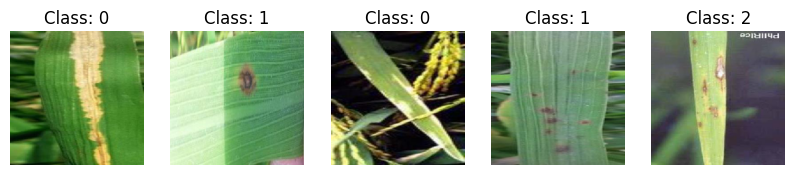

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
images, labels = next(train_generator)

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.show()


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:  # or [-6:] depending on training
    layer.trainable = True

In [ ]:

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-5)  # Lower than ResNet

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# import shutil
# import os

# # Paths to the wrongly placed folders
# wrong_folders = ['/content/banana_leaf_split/train/test', '/content/banana_leaf_split/train/val']
# wrong_folders = ['/content/banana_leaf_split/val/test', '/content/banana_leaf_split/val/val']

# for folder in wrong_folders:
#     if os.path.exists(folder):
#         shutil.rmtree(folder)
#         print(f"Removed: {folder}")
#     else:
#         print(f"Not found: {folder}")




In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    verbose=1
)
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 2217s 21s/step - accuracy: 0.4797 - loss: 1.0685 - val_accuracy: 0.7727 - val_loss: 0.5505
Epoch 2/15
  1/105 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.5938 - loss: 0.8127

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.5938 - loss: 0.8127 - val_accuracy: 0.7770 - val_loss: 0.5439
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.7533 - loss: 0.5828 - val_accuracy: 0.8991 - val_loss: 0.2788
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9062 - loss: 0.2392 - val_accuracy: 0.8949 - val_loss: 0.2856
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 246ms/step - accuracy: 0.8805 - loss: 0.3074 - val_accuracy: 0.9432 - val_loss: 0.1435
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8750 - loss: 0.2803 - val_accuracy: 0.9418 - val_loss: 0.1403
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9402 - loss: 0.1766 - val_accuracy: 0.9631 - val_loss: 0.0864
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 1.0000 - loss: 0.0449 - val_accuracy: 0.9645 - val_loss: 0.0838
Epoch 9/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.9696 - loss: 0.1010 - val_accur

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           77

 Total params: 67,806,539 (258.66 MB)

 Trainable params: 20,057,091 (76.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 40,114,184 (153.02 MB)

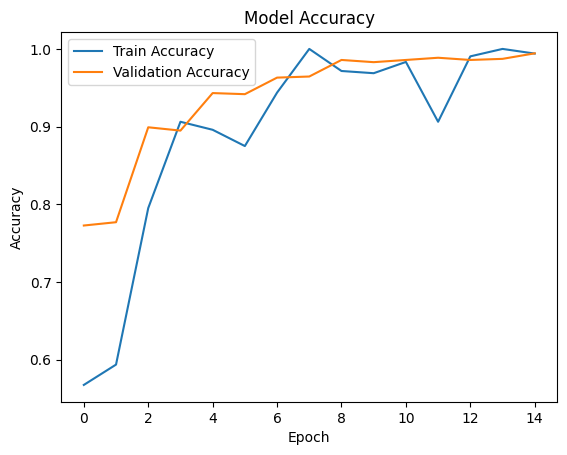

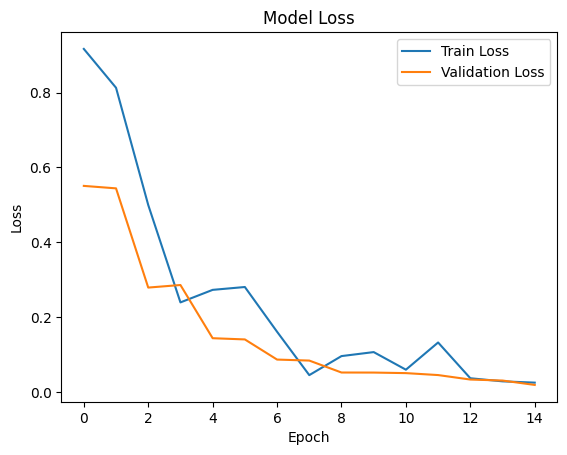

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(train_generator)
print("Train Accuracy:", test_acc)
print("Train Loss:", test_loss)


106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.9999 - loss: 0.0040
Train Accuracy: 0.9997037649154663
Train Loss: 0.0046138339675962925


In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)
print("Validation Loss:", val_loss)


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.9961 - loss: 0.0213
Validation Accuracy: 0.9944674968719482
Validation Loss: 0.01835823245346546


Found 723 images belonging to 3 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step


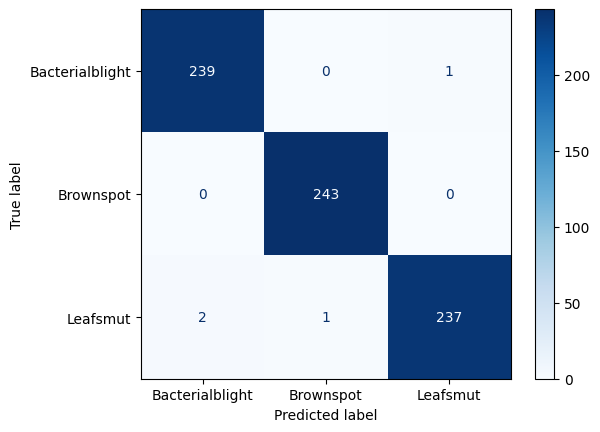

                 precision    recall  f1-score   support

Bacterialblight       0.99      1.00      0.99       240
      Brownspot       1.00      1.00      1.00       243
       Leafsmut       1.00      0.99      0.99       240

       accuracy                           0.99       723
      macro avg       0.99      0.99      0.99       723
   weighted avg       0.99      0.99      0.99       723



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get ground truth labels and predictions
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report (includes precision, recall, F1-score)
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))
